<a href="https://colab.research.google.com/github/masoud-moghini/TinyML/blob/main/ChDeployONPRasbery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [2]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [3]:
print('training set ', '\nData :', trainX.shape, '\nLabel :', trainY.shape)
print('\ntest set', '\nData :', testX.shape, '\nLabel :', testY.shape)

training set  
Data : (50000, 32, 32, 3) 
Label : (50000, 1)

test set 
Data : (10000, 32, 32, 3) 
Label : (10000, 1)


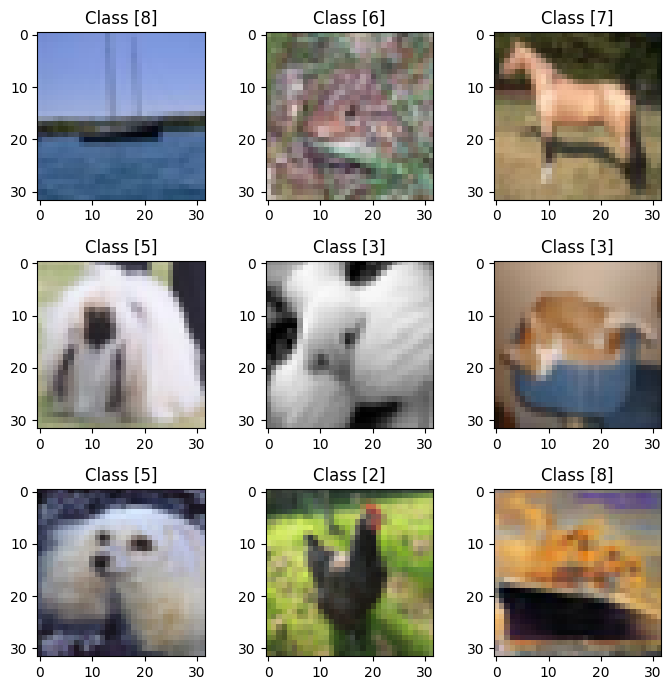

In [4]:
from numpy import random
plt.rcParams['figure.figsize'] = (7,7)
for i in range(9):
  plt.subplot(3,3,i+1)
  num = random.randint(0, len(trainX))
  plt.imshow(trainX[num], cmap='gray')
  plt.title("Class {}".format(trainY[num]))
plt.tight_layout()

In [5]:
from tensorflow.keras.utils import to_categorical
trainX = trainX.astype("float32")
testY = testY.astype("float32")


trainX = trainX / 255;
testX = testX / 255

In [6]:
trainY_one_hot = to_categorical(trainY)
testY_one_hot = to_categorical(testY)

In [17]:
from tensorflow.keras.applications import MobileNet
pretrained_model = MobileNet(input_shape=(32,32,3), include_top=False, weights='imagenet')

In [19]:
pretrained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 16, 16, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 16, 16, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 16, 16, 32) 

In [25]:
def base_model():
  model = Sequential()
  model.add(Dropout(0.3, input_shape=(1,1,1024)))
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(10,activation='softmax'))
  return model

In [ ]:
pip install tensorflow-model-optimization

In [23]:
import tensorflow_model_optimization as tfmot
pretrained_model.trainable = True

In [27]:
basemodel = base_model()
q_pretreained_model = tfmot.quantization.keras.quantize_model(pretrained_model)
q_basemodel = tfmot.quantization.keras.quantize_model(basemodel)

In [29]:
original_inputs = tf.keras.layers.Input(shape = (32, 32, 3))
y = q_pretreained_model(original_inputs)
original_outputs = q_basemodel(y)

In [40]:
model = tf.keras.Model(original_inputs,original_outputs)

In [41]:
model.compile(loss='categorical_crossentropy', metrics = ['accuracy'],optimizer = 'adam')

In [42]:
model.fit(trainX,trainY_one_hot,batch_size=100,epochs=20,validation_split=0.1)

Epoch 1/20
450/450 [==============================] - 90s 148ms/step - loss: 1.2908 - accuracy: 0.5724 - val_loss: 0.9012 - val_accuracy: 0.6914
Epoch 2/20
450/450 [==============================] - 63s 139ms/step - loss: 0.8144 - accuracy: 0.7335 - val_loss: 0.7472 - val_accuracy: 0.7524
Epoch 3/20
450/450 [==============================] - 63s 140ms/step - loss: 0.6628 - accuracy: 0.7839 - val_loss: 0.6713 - val_accuracy: 0.7728
Epoch 4/20
450/450 [==============================] - 63s 140ms/step - loss: 0.5721 - accuracy: 0.8125 - val_loss: 0.6492 - val_accuracy: 0.7862
Epoch 5/20
450/450 [==============================] - 63s 140ms/step - loss: 0.5039 - accuracy: 0.8374 - val_loss: 0.7254 - val_accuracy: 0.7698
Epoch 6/20
450/450 [==============================] - 63s 139ms/step - loss: 0.4601 - accuracy: 0.8485 - val_loss: 0.6273 - val_accuracy: 0.7964
Epoch 7/20
450/450 [==============================] - 63s 139ms/step - loss: 0.4280 - accuracy: 0.8612 - val_loss: 0.6857 - val_ac

In [43]:
model.save("quantized.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
with tfmot.quantization.keras.quantize_scope():
    loaded_model = tf.keras.models.load_model("quantized.h5")

In [50]:
loaded_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 1, 1, 1024)        3241000   
 onal)                                                           
                                                                 
 sequential_2 (Sequential)   (None, 10)                132506    
                                                                 
Total params: 3373506 (12.87 MB)
Trainable params: 3339466 (12.74 MB)
Non-trainable params: 34040 (132.97 KB)
_________________________________________________________________
